In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Library Imports**

In [2]:
import re #libray for regular expression
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Loading Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Github Projects/3. Spam Detection in Emails/completeSpamAssassin.csv')

In [5]:
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


# **Data Cleaning and Preprocessing**

In [8]:
df = df.drop(columns = 'Unnamed: 0', axis='columns')
df = df[df['Body']!= 'empty']

In [9]:
final_df = df

In [10]:
final_df['Body'].duplicated().sum()

221

In [11]:
final_df = final_df.drop_duplicates()

In [12]:
final_df.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [13]:
data = final_df.where((pd.notnull(final_df)), '')

In [14]:
data.isna().sum().sum()

0

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5292 entries, 0 to 6043
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    5292 non-null   object
 1   Label   5292 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 124.0+ KB


In [16]:
data.shape

(5292, 2)

In [17]:
data.reset_index(drop=True, inplace=True)

# **Text Vecorization**

In [18]:
ps = PorterStemmer()
corpus = []
for index, row in data.iterrows():
  review = re.sub('[^a-zA-Z]', ' ', row['Body'])
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus.append(review)

In [19]:
cv = CountVectorizer(max_features = 6000)
X = cv.fit_transform(corpus).toarray()
y = data ['Label']

In [20]:
tfidf = TfidfVectorizer(max_features=6000)
X1 = tfidf.fit_transform(corpus).toarray()
y1 = data['Label']

In [21]:
tokenized_corpus = [sentence.split() for sentence in corpus]

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=500, window=5, min_count=1, workers=4)

# Function to convert sentence to vector
def sentence_vector(sentence, model, vector_size=500):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

# Transform the corpus into vectors
X2 = np.array([sentence_vector(sentence, word2vec_model) for sentence in corpus])

y2 = data['Label']

In [22]:
len(X), len(y)

(5292, 5292)

# **Train Test Split**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state= 3)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1,y1,test_size=0.2, random_state= 3)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2,y2,test_size=0.2, random_state= 3)


# **Oversampling**

In [24]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_train_res_1, y_train_res_1 = smote.fit_resample(X_train_1, y_train_1)
X_train_res_2, y_train_res_2 = smote.fit_resample(X_train_2, y_train_2)

# **Model Training and Performance Metrics**

In [25]:
classifiers = {
    "Multinomial Naive Bayes": (MultinomialNB(), {'alpha': [0.5, 1.0, 1.5]}),
    "Logistic Regression": (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
    "K-Nearest Neighbors": (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    "Decision Tree": (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30]}),
    "Random Forest": (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]})
}

In [26]:
classifiers1 = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
    "K-Nearest Neighbors": (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    "Decision Tree": (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30]}),
    "Random Forest": (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]})
}

In [27]:
best_estimators = {}
performance_metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
}

## Model Training and Perfomance (Count Vectorizer - Bag of Words)



Best Parameters for Multinomial Naive Bayes:
 {'alpha': 0.5}
Confusion Matrix for Multinomial Naive Bayes:
 [[764   4]
 [ 22 269]]
Accuracy Score for Multinomial Naive Bayes: 0.98
Precision for Multinomial Naive Bayes: 0.98
Recall for Multinomial Naive Bayes: 0.98
F1 Score for Multinomial Naive Bayes: 0.98


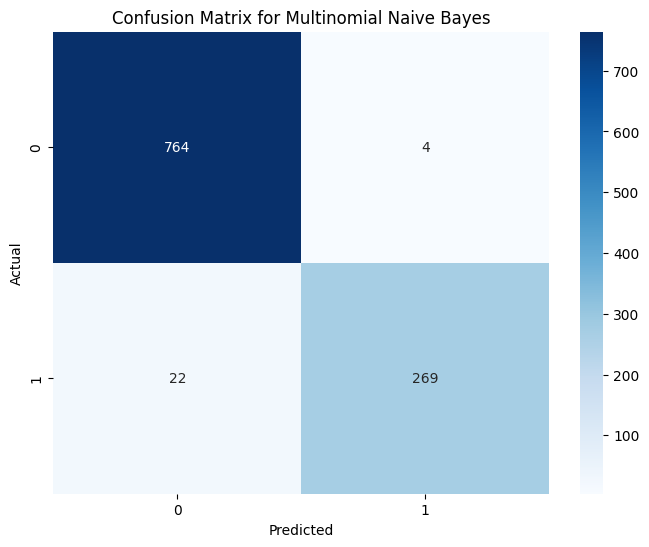

Best Parameters for Logistic Regression:
 {'C': 10}
Confusion Matrix for Logistic Regression:
 [[752  16]
 [  6 285]]
Accuracy Score for Logistic Regression: 0.98
Precision for Logistic Regression: 0.98
Recall for Logistic Regression: 0.98
F1 Score for Logistic Regression: 0.98


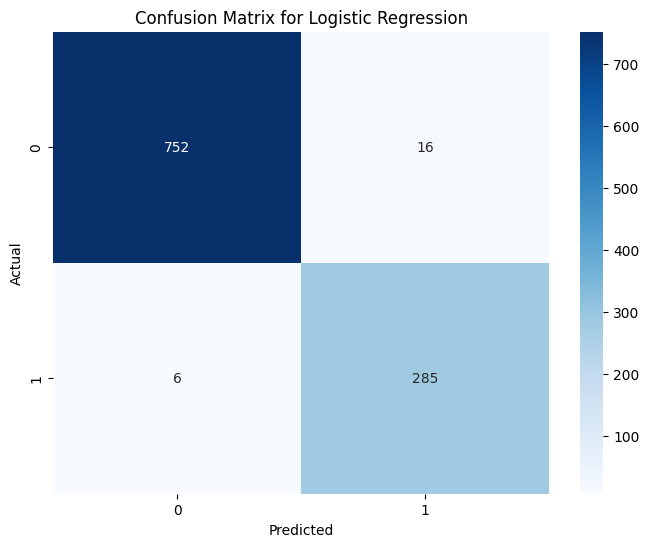

Best Parameters for K-Nearest Neighbors:
 {'n_neighbors': 3}
Confusion Matrix for K-Nearest Neighbors:
 [[543 225]
 [  1 290]]
Accuracy Score for K-Nearest Neighbors: 0.79
Precision for K-Nearest Neighbors: 0.88
Recall for K-Nearest Neighbors: 0.79
F1 Score for K-Nearest Neighbors: 0.80


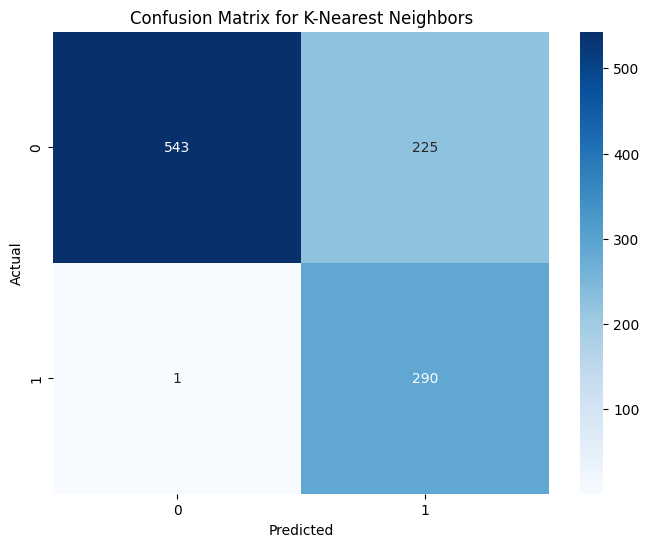

Best Parameters for Decision Tree:
 {'max_depth': None}
Confusion Matrix for Decision Tree:
 [[720  48]
 [ 29 262]]
Accuracy Score for Decision Tree: 0.93
Precision for Decision Tree: 0.93
Recall for Decision Tree: 0.93
F1 Score for Decision Tree: 0.93


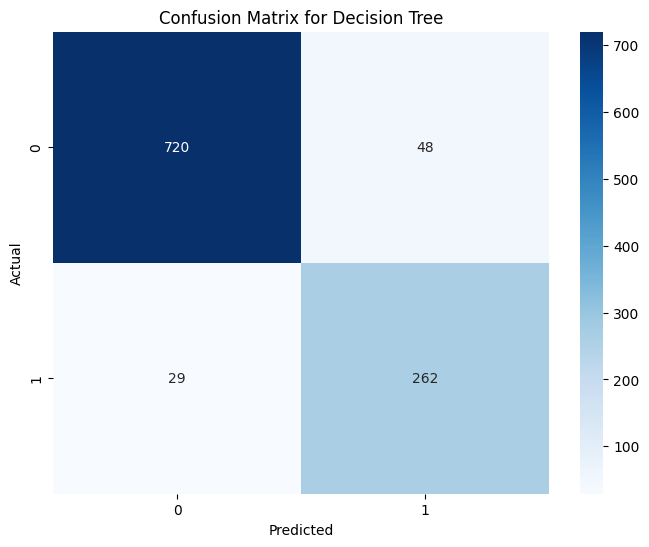

Best Parameters for Random Forest:
 {'max_depth': None, 'n_estimators': 100}
Confusion Matrix for Random Forest:
 [[754  14]
 [  5 286]]
Accuracy Score for Random Forest: 0.98
Precision for Random Forest: 0.98
Recall for Random Forest: 0.98
F1 Score for Random Forest: 0.98


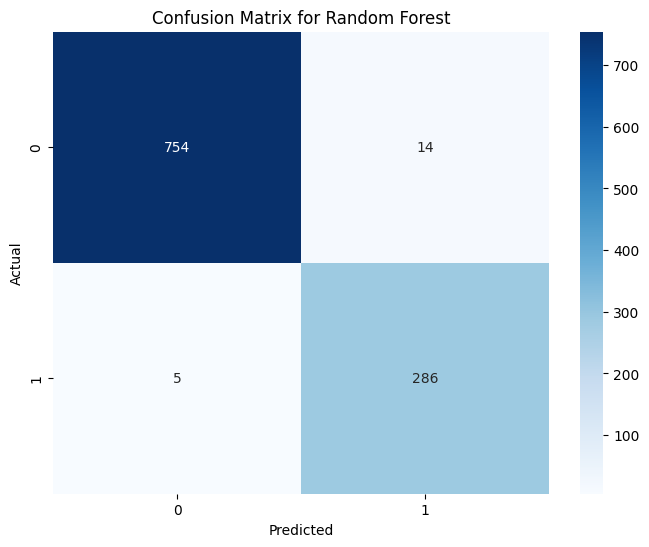

In [28]:
for name, (clf, param_grid) in classifiers.items():
    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_res, y_train_res)
    best_clf = grid_search.best_estimator_
    best_estimators[name] = best_clf
    # Make predictions
    y_pred = best_clf.predict(X_test)
    y_prob = best_clf.predict_proba(X_test)[:, 1] if hasattr(best_clf, 'predict_proba') else None
    # Compute confusion matrix
    confusion = confusion_matrix(y_test, y_pred)
    # Compute performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    performance_metrics['Accuracy'].append(accuracy)
    performance_metrics['Precision'].append(precision)
    performance_metrics['Recall'].append(recall)
    performance_metrics['F1 Score'].append(f1)

    # Print best parameters and performance metrics
    print(f"Best Parameters for {name}:\n", grid_search.best_params_)
    print(f"Confusion Matrix for {name}:\n", confusion)
    print(f"Accuracy Score for {name}: {accuracy:.2f}")
    print(f"Precision for {name}: {precision:.2f}")
    print(f"Recall for {name}: {recall:.2f}")
    print(f"F1 Score for {name}: {f1:.2f}")

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

##Model Training and Performace (Tfidf Vectorization)

Best Parameters for Multinomial Naive Bayes:
 {'alpha': 0.5}
Confusion Matrix for Multinomial Naive Bayes:
 [[759   9]
 [ 11 280]]
Accuracy Score for Multinomial Naive Bayes: 0.98
Precision for Multinomial Naive Bayes: 0.98
Recall for Multinomial Naive Bayes: 0.98
F1 Score for Multinomial Naive Bayes: 0.98


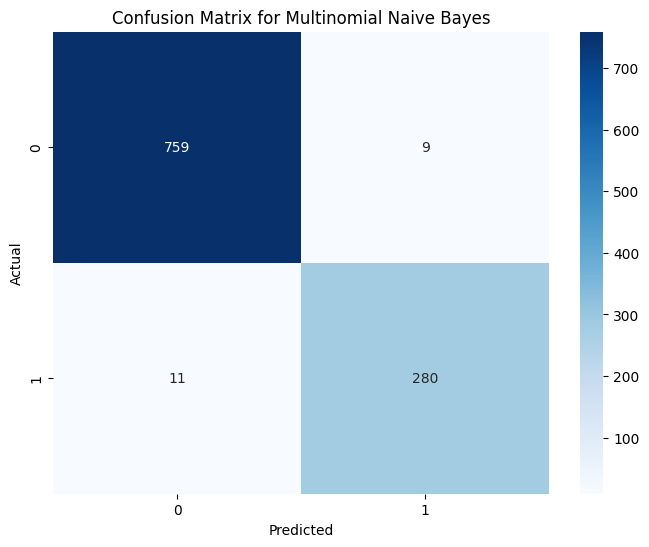

Best Parameters for Logistic Regression:
 {'C': 10}
Confusion Matrix for Logistic Regression:
 [[757  11]
 [  6 285]]
Accuracy Score for Logistic Regression: 0.98
Precision for Logistic Regression: 0.98
Recall for Logistic Regression: 0.98
F1 Score for Logistic Regression: 0.98


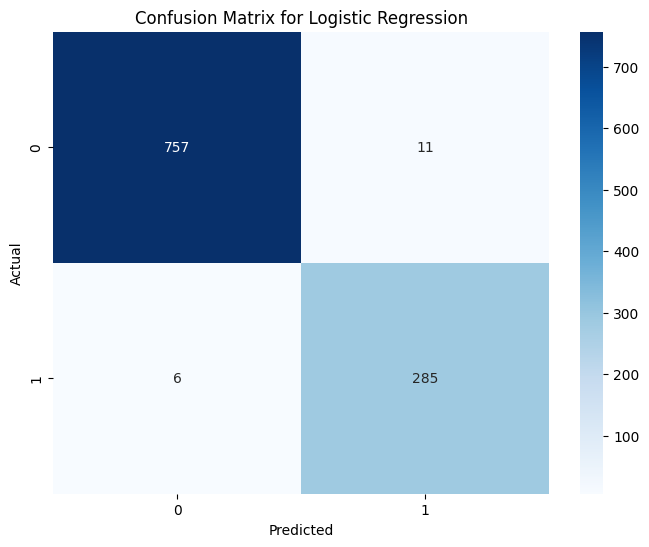

Best Parameters for K-Nearest Neighbors:
 {'n_neighbors': 3}
Confusion Matrix for K-Nearest Neighbors:
 [[292 476]
 [  1 290]]
Accuracy Score for K-Nearest Neighbors: 0.55
Precision for K-Nearest Neighbors: 0.83
Recall for K-Nearest Neighbors: 0.55
F1 Score for K-Nearest Neighbors: 0.55


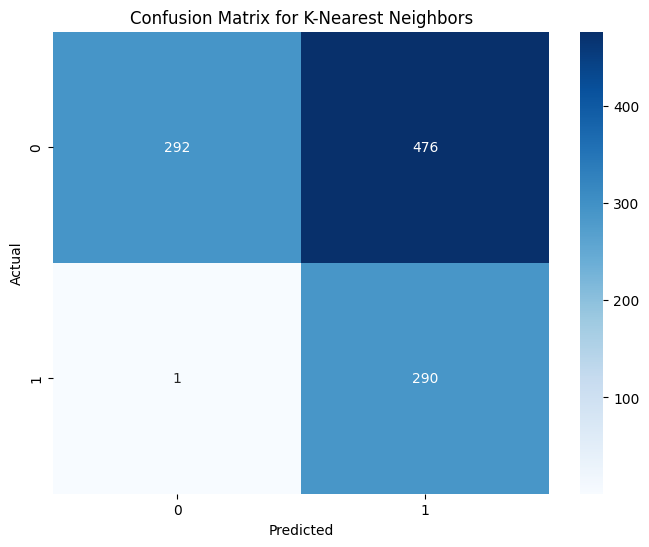

Best Parameters for Decision Tree:
 {'max_depth': None}
Confusion Matrix for Decision Tree:
 [[731  37]
 [ 27 264]]
Accuracy Score for Decision Tree: 0.94
Precision for Decision Tree: 0.94
Recall for Decision Tree: 0.94
F1 Score for Decision Tree: 0.94


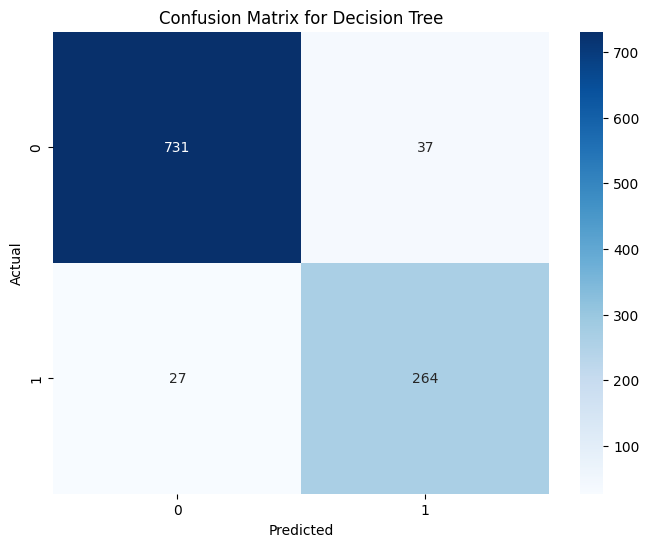

Best Parameters for Random Forest:
 {'max_depth': None, 'n_estimators': 200}
Confusion Matrix for Random Forest:
 [[755  13]
 [  9 282]]
Accuracy Score for Random Forest: 0.98
Precision for Random Forest: 0.98
Recall for Random Forest: 0.98
F1 Score for Random Forest: 0.98


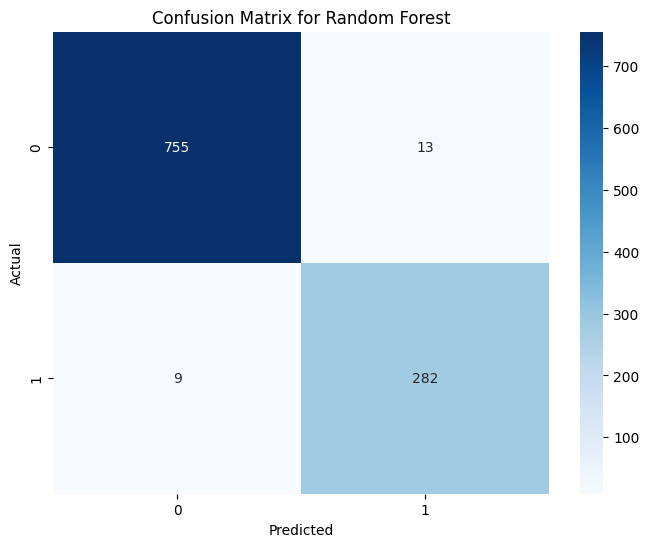

In [29]:
for name, (clf, param_grid) in classifiers.items():
    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_res_1, y_train_res_1)
    best_clf = grid_search.best_estimator_
    best_estimators[name] = best_clf
    # Make predictions
    y_pred = best_clf.predict(X_test_1)
    y_prob = best_clf.predict_proba(X_test_1)[:, 1] if hasattr(best_clf, 'predict_proba') else None
    # Compute confusion matrix
    confusion = confusion_matrix(y_test_1, y_pred)
    # Compute performance metrics
    accuracy = accuracy_score(y_test_1, y_pred)
    precision = precision_score(y_test_1, y_pred, average='weighted')
    recall = recall_score(y_test_1, y_pred, average='weighted')
    f1 = f1_score(y_test_1, y_pred, average='weighted')

    performance_metrics['Accuracy'].append(accuracy)
    performance_metrics['Precision'].append(precision)
    performance_metrics['Recall'].append(recall)
    performance_metrics['F1 Score'].append(f1)

    # Print best parameters and performance metrics
    print(f"Best Parameters for {name}:\n", grid_search.best_params_)
    print(f"Confusion Matrix for {name}:\n", confusion)
    print(f"Accuracy Score for {name}: {accuracy:.2f}")
    print(f"Precision for {name}: {precision:.2f}")
    print(f"Recall for {name}: {recall:.2f}")
    print(f"F1 Score for {name}: {f1:.2f}")

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Best Parameters for Logistic Regression:
 {'C': 10}
Confusion Matrix for Logistic Regression:
 [[722  46]
 [ 18 273]]
Accuracy Score for Logistic Regression: 0.94
Precision for Logistic Regression: 0.94
Recall for Logistic Regression: 0.94
F1 Score for Logistic Regression: 0.94


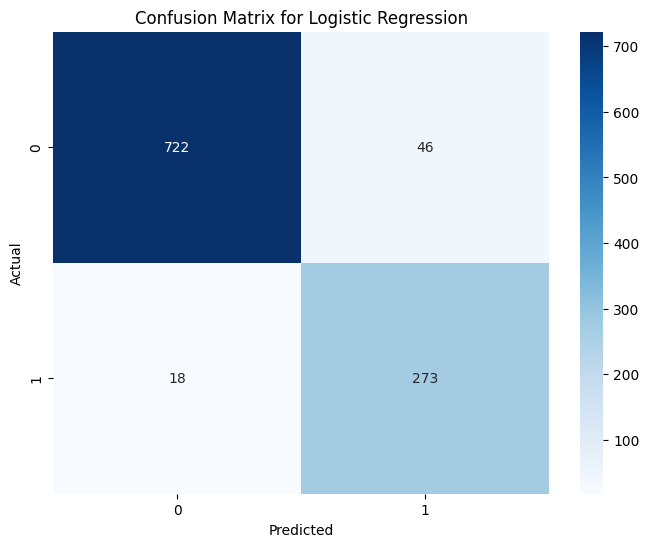

Best Parameters for K-Nearest Neighbors:
 {'n_neighbors': 3}
Confusion Matrix for K-Nearest Neighbors:
 [[722  46]
 [ 14 277]]
Accuracy Score for K-Nearest Neighbors: 0.94
Precision for K-Nearest Neighbors: 0.95
Recall for K-Nearest Neighbors: 0.94
F1 Score for K-Nearest Neighbors: 0.94


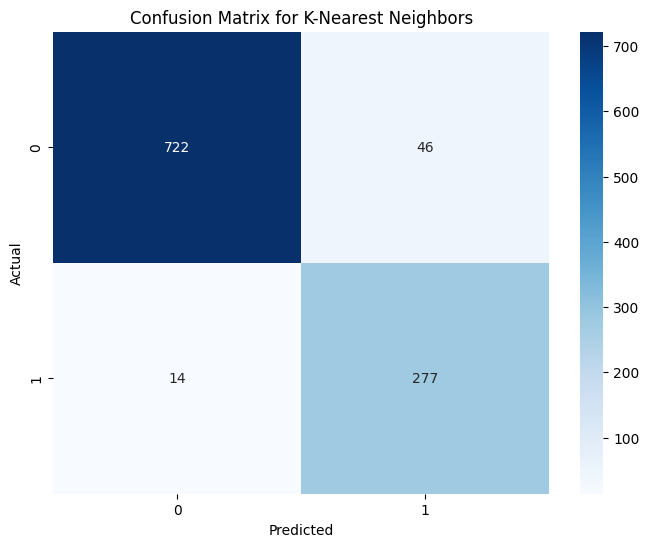

Best Parameters for Decision Tree:
 {'max_depth': 20}
Confusion Matrix for Decision Tree:
 [[715  53]
 [ 38 253]]
Accuracy Score for Decision Tree: 0.91
Precision for Decision Tree: 0.92
Recall for Decision Tree: 0.91
F1 Score for Decision Tree: 0.91


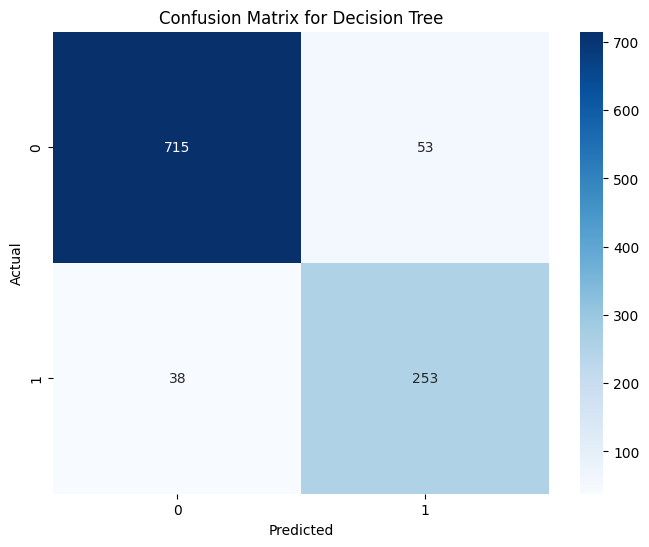

Best Parameters for Random Forest:
 {'max_depth': 30, 'n_estimators': 100}
Confusion Matrix for Random Forest:
 [[746  22]
 [ 21 270]]
Accuracy Score for Random Forest: 0.96
Precision for Random Forest: 0.96
Recall for Random Forest: 0.96
F1 Score for Random Forest: 0.96


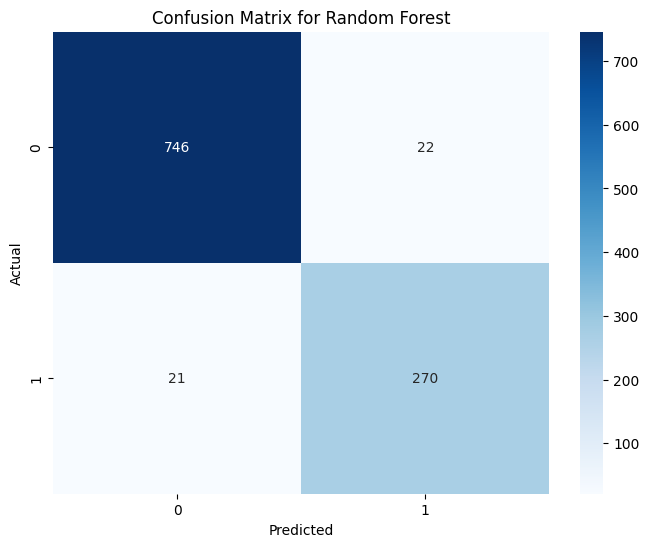

In [30]:
for name, (clf, param_grid) in classifiers1.items():
    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_res_2, y_train_res_2)
    best_clf = grid_search.best_estimator_
    best_estimators[name] = best_clf
    # Make predictions
    y_pred = best_clf.predict(X_test_2)
    y_prob = best_clf.predict_proba(X_test_2)[:, 1] if hasattr(best_clf, 'predict_proba') else None
    # Compute confusion matrix
    confusion = confusion_matrix(y_test_2, y_pred)
    # Compute performance metrics
    accuracy = accuracy_score(y_test_2, y_pred)
    precision = precision_score(y_test_2, y_pred, average='weighted')
    recall = recall_score(y_test_2, y_pred, average='weighted')
    f1 = f1_score(y_test_2, y_pred, average='weighted')

    performance_metrics['Accuracy'].append(accuracy)
    performance_metrics['Precision'].append(precision)
    performance_metrics['Recall'].append(recall)
    performance_metrics['F1 Score'].append(f1)

    # Print best parameters and performance metrics
    print(f"Best Parameters for {name}:\n", grid_search.best_params_)
    print(f"Confusion Matrix for {name}:\n", confusion)
    print(f"Accuracy Score for {name}: {accuracy:.2f}")
    print(f"Precision for {name}: {precision:.2f}")
    print(f"Recall for {name}: {recall:.2f}")
    print(f"F1 Score for {name}: {f1:.2f}")

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()